# Make a quick fit using astropy.modeling

## Authors
Rocio Kiman

## Learning Goals
* Know basic models in Astropy Modeling
* Be able to make a quick fit of your data
* Visualize the fit

## Keywords
Modeling, Fit 

## Summary
In this tutorial, we will become familiar with the models available in `astropy.modeling` and learn how to make a quick fit of our data.

### List of available models

* `Gaussian1D`
* `Trapezoid1D`
* `Polynomial1D`
* `Sine1D`
* `Linear1D`
* The [list](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models) continues.

### List of available fitters

* `LinearLSQFitter()`       A class performing a linear least square fitting.
* `SLSQPLSQFitter()`        SLSQP optimization algorithm and least squares statistic.
* `LevMarLSQFitter()`       Levenberg-Marquardt algorithm and least squares statistic.
* `SimplexLSQFitter()`      Simplex algorithm and least squares statistic.

Check http://docs.astropy.org/en/stable/modeling/ for more information

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astroquery.vizier import Vizier
# Make plots display in notebooks
%matplotlib inline 

## 1) Fit a Lineal model: Three steps to fit data using astropy.modeling

We are going to start with a lineal fit to real data. This data comes from the paper [Bhardwaj et al. 2017](https://ui.adsabs.harvard.edu/?#abs/2017A%26A...605A.100B). To get it, we are going to import it from [Vizier](http://vizier.u-strasbg.fr/viz-bin/VizieR) using [astroquery](http://astroquery.readthedocs.io/en/latest/vizier/vizier.html).

In [2]:
catalog = Vizier.get_catalogs('J/A+A/605/A100')

This catalog has a lot of information, but for this tutorial we are going to work only with periods and magnitudes. Let's grab them using the keywords `'Period'` and `__Ksmag__`.  Note that `'e__Ksmag_'` refers to the error bars in the magnitude measurements.

In [3]:
period = np.array(catalog[0]['Period']) 
log_period = np.log10(period)
k_mag = np.array(catalog[0]['__Ksmag_'])
k_mag_err = np.array(catalog[0]['e__Ksmag_'])

Let's take a look at the magnitude measurements as a function of period:

Text(0,0.5,'Ks')

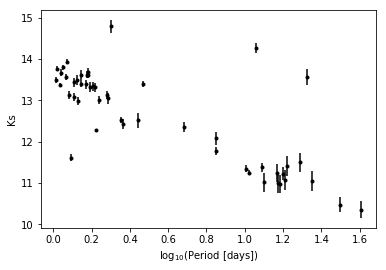

In [4]:
plt.errorbar(log_period, k_mag, k_mag_err, fmt='k.')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')

One could say that there is a linear relationship between log period and magnitudes. To probe it, we want to make a fit to the data. This is where `astropy.modeling` is useful. We are going to understand how in three simple lines we can make any fit we want. But let's start with the linear fit.

#### Let's start with the first step: Set up the model

First we need to choose which model we are going to fit to our data. As we said before, our data looks like a linear relation, so we are going to use a polynomial of degree 1. If you want, you can use `Linear1D` and compare the results.

In [5]:
model = models.Polynomial1D(degree=1)

#### Second step: Set up the fitter

Second we are going to choose the fitter we want to use. This choice is basically which method we want to use to fit the model to the data. In this case we are going to use the [*Linear Least Square Fitting*](https://www.mathworks.com/help/curvefit/least-squares-fitting.html).

In [6]:
fitter = fitting.LinearLSQFitter() 

#### Third step: Fit the data

Finally, we give to our **fitter** (method to fit the data) the **model** and the **data** to perform the fit. Note that we are including weights: This means that values with higher error will have smaller weight (less importance) in the fit, and the contrary for data with smaller errors. This way of fitting is called *Weighted Linear Least Squares* and you can find more information about it [here](https://www.mathworks.com/help/curvefit/least-squares-fitting.html) or [here](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares).

In [7]:
best_fit = fitter(model, log_period, k_mag, weights=1.0/k_mag_err**2)

Let's print the `best_fit` object: 

In [8]:
print(best_fit)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
          c0            c1      
    ------------- --------------
    13.4183588469 -2.09814025751


We can see it has the coefficients for our fit were: `y = c0 + c1*x`.

And that's it!

We can easily evaluate the fit at our particular x axis by doing `best_fit(x)`.

Text(0,0.5,'Ks')

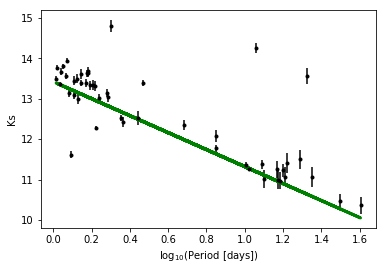

In [9]:
plt.errorbar(log_period,k_mag,k_mag_err,fmt='k.')
plt.plot(log_period, best_fit(log_period), color='g', linewidth=3)  
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')

**Conclusion:** Remember, with three lines you can have your fit:
    > model
    > fitter
    > perform fit

## 2) Fit a Polynomial model: Choose fitter wisely

For second example, lets fit a polynomial of degree more than 1. In this case, we are going to create fake data to make the fit. Note that we are adding gaussian noise to the data with the function `np.random.normal(0,2)` which gives a random number from a gaussian distribution with mean 0 and standard deviation 2.

In [10]:
N = 100
x1 = np.linspace(0, 4, N)  # Makes an array from 0 to 4 of N elements
y1 = x1**3 - 6*x1**2 + 12*x1 - 9 
# Now we add some noise to the data
y1 += np.random.normal(0, 2, size=len(y1))
sigma = 1.5
y1_err = np.ones(N)*sigma 

Let's plot it to see how it looks like:

Text(0,0.5,'$y_1$')

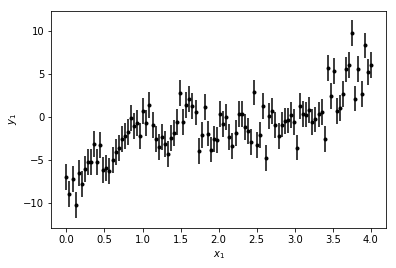

In [11]:
plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.xlabel('$x_1$')  
plt.ylabel('$y_1$')

To fit this data lets remember the three steps: model, fitter and perform fit. 

In [12]:
model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x1, y1, weights = 1.0/y1_err**2)

In [13]:
print(best_fit_poly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
          c0             c1            c2            c3     
    -------------- ------------- ------------- -------------
    -9.06000966335 13.0381725943 -6.8157455188 1.14349294214


What if we don't want to use that fitter (method) to fit the data? Lets use the same model but with a different fitter: `SimplexLSQFitter`.

In [14]:
fitter_poly_2 = fitting.SimplexLSQFitter()
best_fit_poly_2 = fitter_poly_2(model_poly, x1, y1, weights = 1.0/y1_err**2)

In [15]:
print(best_fit_poly_2)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
          c0             c1             c2             c3      
    ------------- --------------- -------------- --------------
    -3.3145490232 -0.130551918288 0.109472844818 0.116166838591


#### Compare results

One way to check which method is best is calculating the [*Reduce Chi Square Value*](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic). Lets define a function to do that because we are going to use it several times.

In [16]:
def calc_reduce_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [17]:
reduce_chi_squared = calc_reduce_chi_square(best_fit_poly(x1), x1, y1, y1_err, N, 4)
print('Reduce Chi Squared with LinearLSQFitter: {}'.format(reduce_chi_squared))

Reduce Chi Squared with LinearLSQFitter: 1.579283642763982


In [18]:
reduce_chi_squared = calc_reduce_chi_square(best_fit_poly_2(x1), x1, y1, y1_err, N, 4)
print('Reduce Chi Squared with SimplexLSQFitter: {}'.format(reduce_chi_squared))

Reduce Chi Squared with SimplexLSQFitter: 2.797836648371634


As we can see, the *Reduce Chi Square* for the first fit is closer to one, which means this fit is better. Note that when we used the second fitter we got a warning saying that as the model is linear, we should use a linear method to fit the data (linear fitter) and that the iteration were not enough to make a good fit. 

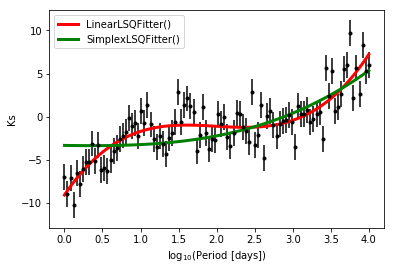

In [19]:
plt.errorbar(x1, y1, yerr=y1_err,fmt='k.')
plt.plot(x1, best_fit_poly(x1), color='r', linewidth=3, label='LinearLSQFitter()')  
plt.plot(x1, best_fit_poly_2(x1), color='g', linewidth=3, label='SimplexLSQFitter()')
plt.xlabel(r'$\log_{10}$(Period [days])')
plt.ylabel('Ks')
plt.legend()

Results are as espected, the fit performed with the linear fitter is better than the second one, non linear. 

**Conclusion:** Pay attention when you choose the fitter.

## 3) Fit a Gaussian: Lets compare to scipy

Maybe some of you know that scipy has the function [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.optimize.curve_fit.html) to fit in a similar way we are doing things. Lets compare the two methods with fake data in the shape of a gaussian.

In [20]:
mu, sigma, amplitude = 0.0, 10.0, 10.0
N2 = 100
x2 = np.linspace(-30, 30, N)
y2 = amplitude * np.exp(-(x2-mu)**2 / (2*sigma**2))
y2 = np.array([y_point + np.random.normal(0, 1) for y_point in y2])
sigma = 1
y2_err = np.ones(N)*sigma

Text(0,0.5,'$y_2$')

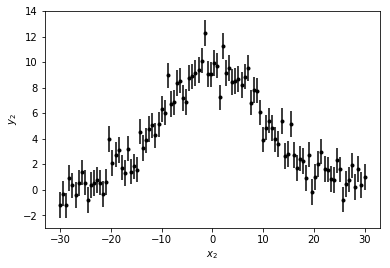

In [21]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')

Lets do our three lines to make the fit we want. Note that we are not going to use the same linear fitter we were using, but one that is not linear (`LevMarLSQFitter`) because now our model requiers it. 

In [22]:
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_gauss = fitter_gauss(model_gauss, x2, y2, weights=1/y2_err**2)

In [23]:
print(best_fit_gauss)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean          stddev   
    ------------- -------------- -------------
    9.72395487725 0.189425842796 10.1753734437


To get the errors on the parameters, for this fitter, we can use `fitter.fit_info['param_cov']` which gives the [covariance matrix](http://mathworld.wolfram.com/CovarianceMatrix.html), and the elements in the diagonal are the errors. We can check the order of the parameters using:

In [24]:
model_gauss.param_names

('amplitude', 'mean', 'stddev')

In [25]:
cov_diag = np.diag(fitter_gauss.fit_info['param_cov'])
print(cov_diag)

[ 0.05304104  0.07739063  0.07769848]


Then:

In [26]:
print('Amplitude: {} +\- {}'.format(best_fit_gauss.amplitude.value, np.sqrt(cov_diag[0])))
print('Mean: {} +\- {}'.format(best_fit_gauss.mean.value, np.sqrt(cov_diag[1])))
print('Standard Deviation: {} +\- {}'.format(best_fit_gauss.stddev.value, np.sqrt(cov_diag[2])))

Amplitude: 9.723954877252499 +\- 0.23030640142630018
Mean: 0.18942584279639157 +\- 0.27819171627296563
Standard Deviation: 10.175373443672884 +\- 0.27874446269366926


Now lets do the same fit but using the method with scipy, and compare the results the same way we did before.

In [27]:
import scipy

def f(x,a,b,c):
    return a * np.exp(-(x-b)**2/(2.0*c**2))

In [28]:
p_opt, p_cov = scipy.optimize.curve_fit(f,x2, y2, sigma=y1_err)
a,b,c = p_opt
best_fit_gauss_2 = f(x2,a,b,c)

In [29]:
print(p_opt)

[  9.72396559   0.18941624  10.17535102]


In [30]:
print('Amplitude: {} +\- {}'.format(p_opt[0], np.sqrt(p_cov[0,0])))
print('Mean: {} +\- {}'.format(p_opt[1], np.sqrt(p_cov[1,1])))
print('Standard Deviation: {} +\- {}'.format(p_opt[2], np.sqrt(p_cov[2,2])))

Amplitude: 9.72396559158729 +\- 0.2303092512510668
Mean: 0.18941624306081026 +\- 0.27818471326408234
Standard Deviation: 10.175351015102358 +\- 0.2787371808734559


#### Compare results

In [31]:
reduce_chi_squared = calc_reduce_chi_square(best_fit_gauss(x2), x2, y2, y2_err, N2, 3)
print('Reduce Chi Squared using astropy.modeling: {}'.format(reduce_chi_squared))

Reduce Chi Squared using astropy.modeling: 1.0510422361113934


In [32]:
reduce_chi_squared = calc_reduce_chi_square(best_fit_gauss_2, x2, y2, y2_err, N2, 3)
print('Reduce Chi Squared using scipy: {}'.format(reduce_chi_squared))

Reduce Chi Squared using scipy: 1.051042236064003


As we can see there is a very small difference in the *Reduce Chi Squared*, but the method with scipy require us to know the function we wanted to fit. In the case of `astropy.modeling`, if you check again the fits we made before, the only thing we changed to make different fits was the name of the model and the fitter.

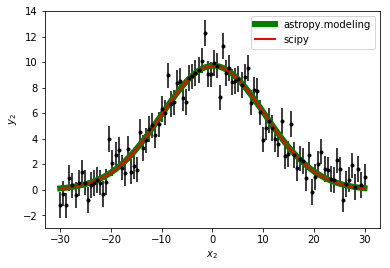

In [33]:
plt.errorbar(x2, y2, yerr=y2_err, fmt='k.')
plt.plot(x2, best_fit_gauss(x2), 'g-', linewidth=6, label='astropy.modeling')
plt.plot(x2, best_fit_gauss_2, 'r-', linewidth=2, label='scipy')
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')
plt.legend()

**Conclusion:** Choose the method most convenient for every case you need to fit. We recomend astropy.modeling to make quick fits of known functions.

## 3) Exercise: Your turn to choose

Exercise: For the next data: 
* Choose model and fitter to fit this data.
* Compare different options.

In [34]:
N3 = 100
x3 = np.linspace(0, 3, N3)
y3 = 5.0 * np.sin(2 * np.pi * x3)
y3 = np.array([y_point + np.random.normal(0, 1) for y_point in y3])
sigma = 1.5
y3_err = np.ones(N)*sigma 

Text(0,0.5,'$y_3$')

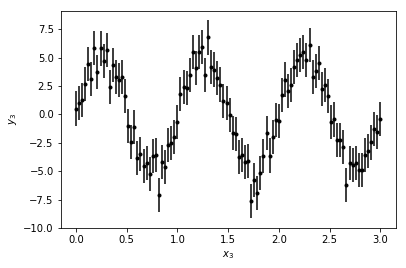

In [35]:
plt.errorbar(x3, y3, yerr=y3_err, fmt='k.')
plt.xlabel('$x_3$')
plt.ylabel('$y_3$')